In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import yasa
import seaborn as sns
import ghibtools as gh
from params import *

In [2]:
patient = 'P1'

In [3]:
data = xr.load_dataarray(f'/crnldata/cmo/Etudiants/Valentin_G/Sleep_EEG_Respi/preproc/{patient}.nc')
hypno = pd.read_excel(f'/crnldata/cmo/Etudiants/Valentin_G/Sleep_EEG_Respi/hypnos/hypno_{patient}.xlsx', index_col = 0)['yasa hypnogram'].values

In [4]:
data

<xarray.DataArray (chan: 16, time: 8135680)>
array([[ 1.50529183e+02,  1.50191271e+02,  1.50805315e+02, ...,
         3.66188653e+01,  3.16137331e+01,  4.09883268e+01],
       [ 6.90894942e+01,  6.82894568e+01,  6.82945179e+01, ...,
         7.91938602e+01,  7.83772786e+01,  7.55330739e+01],
       [-6.08560311e+01, -5.40292796e+01, -5.20637536e+01, ...,
        -1.07113174e+02, -1.08970853e+02, -1.04350195e+02],
       ...,
       [ 3.50906615e+02,  4.32703797e+02,  5.63207479e+02, ...,
         6.00099189e+02,  7.06561343e+02,  7.57389105e+02],
       [-3.10902571e+06, -3.11244472e+06, -3.11953327e+06, ...,
        -9.76298840e+05, -9.86485334e+05, -1.01091020e+06],
       [ 3.46789883e+02,  3.48205014e+02,  3.52208052e+02, ...,
         4.29675266e+01,  3.85529983e+01,  4.10778210e+01]])
Coordinates:
  * time     (time) float64 0.0 0.003906 0.007812 ... 3.178e+04 3.178e+04
  * chan     (chan) object 'Fp2-C4' 'C4-T4' 'T4-O2' ... 'EOGG' 'DEBIT' 'THERM'
Attributes:
    unit:     uV
    srate:    256.0

In [5]:
hypno.shape

(1059,)

In [6]:
sf_hypno = 1/30
hypno_upsample = yasa.hypno_upsample_to_data(hypno, sf_hypno, data, sf_data=srate, verbose=True)
hypno_upsampled_int = yasa.hypno_str_to_int(hypno_upsample)

21-Nov-22 18:08:11 | WARNING | Hypnogram is SHORTER than data by 10.00 seconds. Padding hypnogram with last value to match data.size.


In [7]:
data_eeg = data.sel(chan = eeg_chans)

In [8]:
data_eeg

<xarray.DataArray (chan: 8, time: 8135680)>
array([[ 150.52918288,  150.19127105,  150.80531456, ...,   36.6188653 ,
          31.61373306,   40.98832685],
       [  69.08949416,   68.28945681,   68.2945179 , ...,   79.19386016,
          78.3772786 ,   75.53307393],
       [ -60.85603113,  -54.02927956,  -52.06375356, ..., -107.11317359,
        -108.97085314, -104.35019455],
       ...,
       [ 238.77042802,  237.84142219,  235.8307037 , ...,  172.90292907,
         177.26691218,  177.55642023],
       [-219.43968872, -220.89509216, -219.46120471, ...,  -69.67244728,
         -67.33116472,  -68.37354086],
       [ 173.61867704,  176.77868483,  172.53304608, ...,   23.02490697,
          20.17191843,   22.73151751]])
Coordinates:
  * time     (time) float64 0.0 0.003906 0.007812 ... 3.178e+04 3.178e+04
  * chan     (chan) object 'Fp2-C4' 'C4-T4' 'T4-O2' ... 'Fp1-C3' 'C3-T3' 'T3-O1'
Attributes:
    unit:     uV
    srate:    256.0

In [9]:
sp = yasa.spindles_detect(data=data_eeg, sf=srate, ch_names=eeg_chans, multi_only=False, remove_outliers=True, duration=(0.5, 2), min_distance=500, thresh={'corr': 0.8, 'rel_pow': 0.4, 'rms': 1.5}, hypno = hypno_upsampled_int, include = (0,1,2,3,4))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    3.3s finished


In [10]:
sps = sp.summary()
mapper = {0:'W',1:'N1',2:'N2',3:'N3',4:'REM'}
sps['Stage_Letter'] = sps['Stage'].map(mapper)

In [11]:
sps['Stage_Letter'].value_counts()

N2     914
N3       3
N1       1
W        1
REM      1
Name: Stage_Letter, dtype: int64

In [12]:
sps

,Start,Peak,End,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry,Stage,Channel,IdxChannel,Stage_Letter
0,3751.773438,3752.152344,3752.355469,0.582031,44.931074,11.038809,2.302837,0.562434,12.819284,7.0,0.646667,2,Fp2-C4,0,N2
1,3781.347656,3782.242188,3782.527344,1.179688,69.673285,13.270767,2.344561,0.641495,12.960701,15.0,0.755776,2,Fp2-C4,0,N2
2,3977.203125,3977.582031,3977.750000,0.546875,49.722653,13.873621,2.512609,0.582627,13.022612,7.0,0.687943,2,Fp2-C4,0,N2
3,4086.750000,4086.785156,4087.285156,0.535156,66.973174,15.769378,2.523259,0.547331,14.065248,7.0,0.065217,2,Fp2-C4,0,N2
4,4146.382812,4146.730469,4147.191406,0.808594,81.347117,18.013307,2.508374,0.478959,13.531399,10.0,0.427885,2,Fp2-C4,0,N2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,12565.855469,12566.179688,12566.464844,0.609375,60.882273,13.209732,2.286101,0.534287,13.876829,8.0,0.528662,2,T3-O1,7,N2
916,12798.925781,12799.328125,12799.441406,0.515625,70.301156,15.565172,2.538984,0.451823,14.440173,7.0,0.774436,2,T3-O1,7,N2
917,17570.722656,17571.042969,17571.656250,0.933594,86.572248,18.943881,2.694020,0.625506,14.119676,13.0,0.341667,2,T3-O1,7,N2
918,18090.109375,18090.304688,18090.902344,0.792969,41.454281,9.171116,1.906188,0.498988,13.894470,11.0,0.245098,2,T3-O1,7,N2


In [13]:
freq_sw = (0.3, 1.5) # Slow wave frequency range, in Hz
sw_dur_neg = (0.3, 1.5) # The minimum and maximum duration of the negative deflection of the slow wave, in secs
sw_dur_pos = (0.1, 1) # The minimum and maximum duration of the positive deflection of the slow wave, in secs
sw_dur_pos = (0.1, 1) # The minimum and maximum duration of the positive deflection of the slow wave, in secs
sw_amp_neg = (60,200) # Absolute minimum and maximum negative trough amplitude of the slow-wave. In µV
sw_amp_pos = (20,150) # Absolute minimum and maximum positive peak amplitude of the slow-wave. In µV
sw_amp_ptp = (85,350) # Minimum and maximum peak-to-peak amplitude of the slow-wave. In µV

In [14]:
sw = yasa.sw_detect(data=data_eeg, sf=srate, ch_names=eeg_chans, hypno=hypno_upsampled_int, include=(0,1,2,3,4), freq_sw=freq_sw, dur_neg=sw_dur_neg, dur_pos=sw_dur_pos, amp_neg=sw_amp_neg, amp_pos=sw_amp_neg, amp_ptp=sw_amp_ptp, coupling=True, remove_outliers=True, verbose=False)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    3.2s finished


In [15]:
sws = sw.summary()

In [16]:
sws['Stage_Letter'] = sws['Stage'].map(mapper)

In [17]:
sws

,Start,NegPeak,MidCrossing,PosPeak,End,Duration,ValNegPeak,ValPosPeak,PTP,Slope,Frequency,SigmaPeak,PhaseAtSigmaPeak,ndPAC,Stage,Channel,IdxChannel,Stage_Letter
0,40.796875,41.089844,41.671875,42.027344,42.300781,1.5039,-127.592093,104.165656,231.757749,398.187810,0.664938,41.847656,-0.961795,0.254619,0,Fp2-C4,0,W
1,46.718750,47.070312,47.351562,47.574219,48.253906,1.5352,-152.414061,91.900104,244.314165,868.672586,0.651381,47.457031,-1.021984,0.180842,0,Fp2-C4,0,W
2,51.574219,51.828125,52.050781,52.238281,52.433594,0.8594,-96.525581,70.402588,166.928169,749.712476,1.163603,52.179688,-0.680382,0.392585,0,Fp2-C4,0,W
3,64.417969,64.738281,65.019531,65.246094,65.609375,1.1914,-105.438001,63.183263,168.621264,599.542272,0.839349,64.402344,1.484368,0.126504,0,Fp2-C4,0,W
4,611.187500,611.531250,611.839844,612.191406,612.585938,1.3984,-87.696269,133.952406,221.648675,718.253934,0.715103,611.894531,-1.322108,0.308584,0,Fp2-C4,0,W
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
756,20657.199219,20657.488281,20657.742188,20657.964844,20658.300781,1.1016,-98.461181,71.113752,169.574934,667.864354,0.907771,20656.773438,-2.654438,0.366818,2,T3-O1,7,N2
757,22911.925781,22912.246094,22912.480469,22912.796875,22913.113281,1.1875,-65.114769,108.210941,173.325711,739.523032,0.842105,22911.683594,1.094696,0.295158,4,T3-O1,7,REM
758,26052.515625,26052.843750,26053.136719,26053.500000,26053.949219,1.4336,-74.815440,68.163297,142.978737,488.034090,0.697545,26053.117188,-1.658658,0.221455,2,T3-O1,7,N2
759,26055.234375,26055.476562,26055.707031,26055.925781,26056.269531,1.0352,-81.997451,62.850192,144.847642,628.491465,0.965997,26054.742188,-2.265879,0.369293,2,T3-O1,7,N2


In [18]:
sws.shape

(761, 18)

In [19]:
sws

,Start,NegPeak,MidCrossing,PosPeak,End,Duration,ValNegPeak,ValPosPeak,PTP,Slope,Frequency,SigmaPeak,PhaseAtSigmaPeak,ndPAC,Stage,Channel,IdxChannel,Stage_Letter
0,40.796875,41.089844,41.671875,42.027344,42.300781,1.5039,-127.592093,104.165656,231.757749,398.187810,0.664938,41.847656,-0.961795,0.254619,0,Fp2-C4,0,W
1,46.718750,47.070312,47.351562,47.574219,48.253906,1.5352,-152.414061,91.900104,244.314165,868.672586,0.651381,47.457031,-1.021984,0.180842,0,Fp2-C4,0,W
2,51.574219,51.828125,52.050781,52.238281,52.433594,0.8594,-96.525581,70.402588,166.928169,749.712476,1.163603,52.179688,-0.680382,0.392585,0,Fp2-C4,0,W
3,64.417969,64.738281,65.019531,65.246094,65.609375,1.1914,-105.438001,63.183263,168.621264,599.542272,0.839349,64.402344,1.484368,0.126504,0,Fp2-C4,0,W
4,611.187500,611.531250,611.839844,612.191406,612.585938,1.3984,-87.696269,133.952406,221.648675,718.253934,0.715103,611.894531,-1.322108,0.308584,0,Fp2-C4,0,W
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
756,20657.199219,20657.488281,20657.742188,20657.964844,20658.300781,1.1016,-98.461181,71.113752,169.574934,667.864354,0.907771,20656.773438,-2.654438,0.366818,2,T3-O1,7,N2
757,22911.925781,22912.246094,22912.480469,22912.796875,22913.113281,1.1875,-65.114769,108.210941,173.325711,739.523032,0.842105,22911.683594,1.094696,0.295158,4,T3-O1,7,REM
758,26052.515625,26052.843750,26053.136719,26053.500000,26053.949219,1.4336,-74.815440,68.163297,142.978737,488.034090,0.697545,26053.117188,-1.658658,0.221455,2,T3-O1,7,N2
759,26055.234375,26055.476562,26055.707031,26055.925781,26056.269531,1.0352,-81.997451,62.850192,144.847642,628.491465,0.965997,26054.742188,-2.265879,0.369293,2,T3-O1,7,N2


In [20]:
sws['Channel'].value_counts()

T4-O2     192
T3-O1     156
Fp2-C4    120
C3-T3      95
Fp1-C3     88
C4-T4      53
Fz-Cz      40
Cz-Pz      17
Name: Channel, dtype: int64

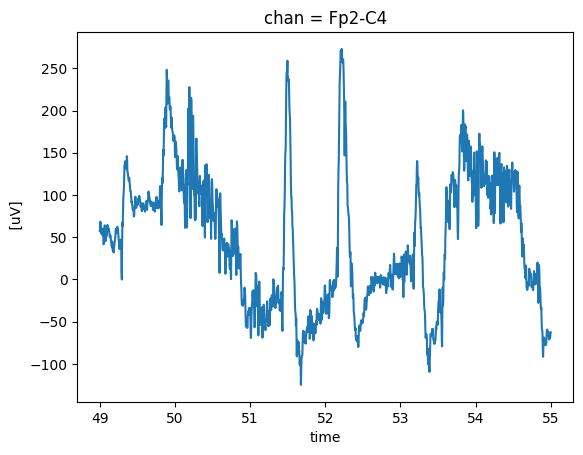

In [21]:
data.loc['Fp2-C4',49:55].plot()

In [22]:
%matplotlib widget

In [23]:
peaks

NameError: name 'peaks' is not defined

In [ ]:
sig_keep.shape

In [ ]:
t_keep.shape

In [ ]:
start = 35
stop = 75

neg_peaks_times = sws['NegPeak'].values
keep_peaks = (neg_peaks_times > start) & (neg_peaks_times < stop)
t_sw = neg_peaks_times[keep_peaks]
print(t_sw)

t = data.coords['time'].values
t_mask = (t> start) & (t < stop)
sig = data.loc['Fp2-C4',:].values
t_sig = t[t_mask]
sig_keep = sig[t_mask]

y_sw = sig[np.isin(t, t_sw)]

fig, ax = plt.subplots()
ax.plot(t_sig, sig_keep)
ax.plot(t_sw, y_sw, 'o')
plt.show()

In [ ]:
y_sw